In [1]:
import json

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
test_split = 0.2

In [7]:
with open("sarcasm.json", "r") as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=test_split, random_state=42)

y_train, y_test = np.array(y_train), np.array(y_test)

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_seq = tokenizer.texts_to_sequences(X_train)
training_pad = pad_sequences(training_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_seq = tokenizer.texts_to_sequences(X_test)
testing_pad = pad_sequences(testing_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 162,305
Trainable params: 162,305
Non-trainable params: 0
_________________________________________________________________


In [34]:
class StopTrain(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") >= 0.9 and logs.get("val_accuracy") > 0.85:
            print("Reached desired accuracy. Stopping training")
            self.model.stop_training = True

callbacks = StopTrain()

num_epochs = 30

history = model.fit(
    training_pad,
    y_train,
    batch_size=32,
    steps_per_epoch=100,
    epochs=num_epochs,
    validation_data=(testing_pad, y_test),
    callbacks=[callbacks]
)

Epoch 1/30
100/100 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.5525 - val_loss: 0.6815 - val_accuracy: 0.5608
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5700 - val_loss: 0.6447 - val_accuracy: 0.7098
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.7559 - val_loss: 0.5073 - val_accuracy: 0.8152
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4690 - accuracy: 0.7978 - val_loss: 0.4245 - val_accuracy: 0.8128
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.4149 - accuracy: 0.8159 - val_loss: 0.3839 - val_accuracy: 0.8381
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8344 - val_loss: 0.3687 - val_accuracy: 0.8388
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3356 - accuracy: 0.8596 - val_loss: 0.3590 - val_accuracy: 0.8429
Epoch 

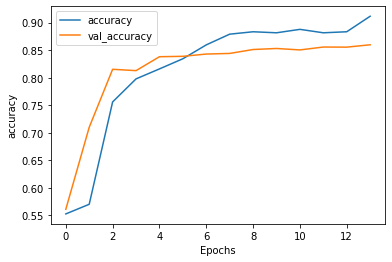

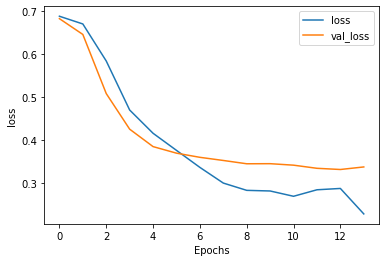

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [42]:
sentence = ["annoying man yells at congress", "the war has ended"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
model.predict(padded)

array([[0.9529042 ],
       [0.12212786]], dtype=float32)